In [166]:
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from itertools import combinations
from collections import defaultdict
from statistics import mean
from scipy.stats import pearsonr
import numpy as np

import matplotlib.pylab as plt
import RNA

In [2]:
## 1 = Experiment data, 0 = Model data
DATA_SOURCE_EXP = 1

In [50]:
## Reading input data

#### Reading Cas13d guides

fasta_sequences = SeqIO.parse(open("data/Cas13d_GFP_library.final.fa"),'fasta')
fasta_sequences = [f for f in fasta_sequences][533:933] ## Hardcoded range of all perfect matches

name_to_seq = {}
seq_to_name = {}

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    name_to_seq[name] = sequence
    seq_to_name[sequence] = name
    
#### Reading GFP sequence

gfp_sequence = SeqIO.parse(open("data/GFP.fa"),'fasta')

gfp_seq = None

for s in gfp_sequence:
    gfp_seq = str(s.seq)

fold_with_gfp = lambda seq: RNA.fold_compound(gfp_seq + "&" + seq)
get_mfe_with_gfp = lambda seq: fold_with_gfp(seq).mfe_dimer()[1]

#### Reading results of guide tiling screen on GFP, selecting only perfect matches

guides_df = pd.read_csv('data/guides.csv')
guides_df = guides_df[guides_df.Screen == 'GFP']
guides_df = guides_df[guides_df.MatchType == 'Perfect Match'].reset_index(drop=True)
guides_df["GuideSeq"] = guides_df.GuideName.apply(lambda x: name_to_seq[x])
guides_df['mfe'] = guides_df["GuideSeq"].apply(get_mfe_with_gfp)
guides_df

,Screen,GuideName,Guide,MatchType,MatchPos,Annotation,log2FC,pVal,GuideSeq,mfe
0,GFP,crRNA001:1-27,crRNA001,Perfect Match,27.0,CDS,0.697829,0.037139,GGTGAACAGCTCCTCGCCCTTGCTCAC,-301.899994
1,GFP,crRNA002:2-28,crRNA002,Perfect Match,28.0,CDS,0.973334,0.005306,CGGTGAACAGCTCCTCGCCCTTGCTCA,-299.200012
2,GFP,crRNA003:6-32,crRNA003,Perfect Match,32.0,CDS,1.166888,0.052775,ACCCCGGTGAACAGCTCCTCGCCCTTG,-295.399994
3,GFP,crRNA004:7-33,crRNA004,Perfect Match,33.0,CDS,1.054580,0.009933,CACCCCGGTGAACAGCTCCTCGCCCTT,-295.899994
4,GFP,crRNA005:9-35,crRNA005,Perfect Match,35.0,CDS,0.850457,0.161384,ACCACCCCGGTGAACAGCTCCTCGCCC,-297.500000
...,...,...,...,...,...,...,...,...,...,...
395,GFP,crRNA396:682-708,crRNA396,Perfect Match,708.0,CDS,0.630859,0.102021,CAGCTCGTCCATGCCGAGAGTGATCCC,-297.700012
396,GFP,crRNA397:684-710,crRNA397,Perfect Match,710.0,CDS,0.316832,0.218475,TACAGCTCGTCCATGCCGAGAGTGATC,-294.299988
397,GFP,crRNA398:685-711,crRNA398,Perfect Match,711.0,CDS,-0.144896,0.870466,GTACAGCTCGTCCATGCCGAGAGTGAT,-296.799988
398,GFP,crRNA399:686-712,crRNA399,Perfect Match,712.0,CDS,0.087081,0.575302,TGTACAGCTCGTCCATGCCGAGAGTGA,-296.299988


In [54]:
model_df = pd.read_csv("data/pHKO32_GFP_CasRxguides.csv")
model_df['mfe'] = model_df["GuideSeq"].apply(get_mfe_with_gfp)
model_df

,GuideName,GuideSeq,MatchPos,GuideScores,Rank,standardizedGuideScores,quartiles,mfe
0,crRNA433:433-459,CATGATATAGACGTTGTGGCTGTTGTA,459,1.201356,0.998500,0.826052,4,-286.899994
1,crRNA434:434-460,CCATGATATAGACGTTGTGGCTGTTGT,460,1.095951,0.997100,0.767515,4,-286.899994
2,crRNA432:432-458,ATGATATAGACGTTGTGGCTGTTGTAG,458,1.092283,0.995600,0.765478,4,-286.700012
3,crRNA405:405-431,TTGTACTCCAGCTTGTGCCCCAGGATG,431,1.015784,0.994200,0.722994,4,-292.299988
4,crRNA406:406-432,GTTGTACTCCAGCTTGTGCCCCAGGAT,432,0.972281,0.992700,0.698835,4,-292.899994
...,...,...,...,...,...,...,...,...
683,crRNA166:166-192,CAGGGTGGTCACGAGGGTGGGCCAGGG,192,-0.326007,0.005814,0.000000,1,-295.799988
684,crRNA673:673-699,CATGCCGAGAGTGATCCCGGCGGCGGT,699,-0.328984,0.004360,0.000000,1,-297.100006
685,crRNA569:569-595,GGTTGTCGGGCAGCAGCACGGGGCCGT,595,-0.331601,0.002907,0.000000,1,-296.500000
686,crRNA162:162-188,GTGGTCACGAGGGTGGGCCAGGGCACG,188,-0.352561,0.001453,0.000000,1,-293.700012


In [5]:
## Get all CCA start positions in GFP

def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += 1
        
match_pos = [x for x in find_all(gfp_seq, 'CCA')]

In [6]:
def get_all_substrs_of_length(string, k):
    substrs = []
        
    if k > len(string):
        return substrs
    for i in range(0, len(string)-k+1):
        substrs.append(string[i:i+k])
        
    return substrs

def get_all_substrs_of_length_containing_slice(string, slice_start, slice_end, substr_len):
    ## Returns all substrings of a length in a string that contain the specified slice
    ## No unit tests :(
    slice_len = slice_end - slice_start + 1
    assert slice_len > 0
    
    start = max(0, slice_start - (substr_len - slice_len))
    end = min(len(string), slice_start + substr_len)
    return get_all_substrs_of_length(string[start:end], substr_len)

def get_all_substrs_of_length_containing_slice_with_slice_index(string, slice_start, slice_end, substr_len):
    ## Returns the same as get_all_substrs_of_length_containing_slice, but in a dictionary
    ## Where the keys are the indexes of the slice within the substring and the values are the substrings
    ## Relies on implementation of get_all_substrs_of_length returning a particular order
    ## No unit tests :(
    slice_len = slice_end - slice_start + 1
    assert slice_len > 0
    
    start = max(0, slice_start - (substr_len - slice_len))
    end = min(len(string), slice_start + substr_len)
    substrs = get_all_substrs_of_length(string[start:end], substr_len)[::-1]
    
    first_slice_index = slice_start + substr_len - end # 0 if equal, else increase since not full string
    
    indexed_substrs = {}
    for i, substr in enumerate(substrs):
        indexed_substrs[i + first_slice_index] = substr
        
    return indexed_substrs

def get_substr_with_center_slice_of_length(string, slice_start, slice_end, substr_len):
    ## Returns the substring with the slice of interest smack in the middle
    
    slice_len = slice_end - slice_start + 1
    side_length = substr_len - slice_len
    assert side_length >= 0
    
    r_len = None
    l_len = None
    if side_length % 2 == 0:
        r_len = int(side_length / 2)
        l_len = r_len
    else:
        r_len = int(side_length / 2)
        l_len = r_len + 1
    
    if slice_start - l_len < 0 or slice_end + r_len >= len(string):
        print("No valid substr of length {} with slice in middle".format(substr_len))
        return
    
    return string[slice_start-l_len : slice_end+r_len+1]

def reverse_complement(string):
    return str(Seq(string).reverse_complement())

In [106]:
## Collect guides for each of our three treatments (x2 for different lengths)

center_stop_27 = {}
center_stop_54 = {}

all_stops_27 = {}
all_stops_54 = {}

stop_position_variation_27 = defaultdict(list)
stop_position_variation_54 = defaultdict(list)

for slice_start in match_pos:
    slice_end = slice_start + 2
    ## Note that the data is going to be indexed by the start of the CCA
    ## This could make it tricky to compare the data with center stop vs varied stop
    center_stop_27[slice_start] = reverse_complement(get_substr_with_center_slice_of_length(gfp_seq, slice_start, 
                                                                                            slice_end, 27))
    center_stop_54[slice_start] = reverse_complement(get_substr_with_center_slice_of_length(gfp_seq, slice_start, 
                                                                                            slice_end, 54))
    
    substrs_27 = get_all_substrs_of_length_containing_slice_with_slice_index(gfp_seq, slice_start, 
                                                                             slice_end, 27)
    substrs_54 = get_all_substrs_of_length_containing_slice_with_slice_index(gfp_seq, slice_start, 
                                                                             slice_end, 54)
    
    all_stops_27[slice_start] = [x for x in map(reverse_complement, list(substrs_27.values()))]
    all_stops_54[slice_start] = [x for x in map(reverse_complement, list(substrs_54.values()))]
    
    for k, v in substrs_27.items():
        stop_position_variation_27[k].append(v)
        
    for k, v in substrs_54.items():
        stop_position_variation_54[k].append(v)
        
for k, v in stop_position_variation_27.items():
    stop_position_variation_27[k] = list(map(reverse_complement, v))
    
for k, v in stop_position_variation_54.items():
    stop_position_variation_54[k] = list(map(reverse_complement, v))

In [57]:
if DATA_SOURCE_EXP:
    data_df = guides_df
    data_df["score"] = data_df.log2FC
else:
    data_df = model_df
    data_df["score"] = data_df.GuideScores

In [60]:
center_stop_27_data = {}

for i, seq in center_stop_27.items():
    row = data_df[data_df.GuideSeq == seq]
    if len(row):
        center_stop_27_data[i] = (row.score.iloc[0], row.mfe.iloc[0])
        
center_stop_54_data = {}

for i, seq in center_stop_54.items():
    s1 = seq[:len(seq)//2]
    s2 = seq[len(seq)//2:]
    r1 = data_df[data_df.GuideSeq == s1]
    r2 = data_df[data_df.GuideSeq == s2]
    if len(r1) and len(r2):
        center_stop_54_data[i] = ((r1.score.iloc[0] + r2.score.iloc[0])/2, 
                                  (r1.mfe.iloc[0] + r2.mfe.iloc[0])/2)

In [61]:
all_stops_27_data = {}

for i, seq in all_stops_27.items():
    row = data_df[data_df.GuideSeq.isin(seq)]
    if len(row):
        all_stops_27_data[i] = (row.score.mean(), row.mfe.mean())
        
all_stops_54_data = {}

for i, seqs in all_stops_54.items():
    scores = []
    mfes = []
    for seq in seqs:
        s1 = seq[:len(seq)//2]
        s2 = seq[len(seq)//2:]
        r1 = data_df[data_df.GuideSeq == s1]
        r2 = data_df[data_df.GuideSeq == s2]
        if len(r1) and len(r2):
            scores.append((r1.score.iloc[0] + r2.score.iloc[0])/2)
            mfes.append((r1.mfe.iloc[0] + r2.mfe.iloc[0])/2)
            
    try:
        all_stops_54_data[i] = (mean(scores), mean(mfes))
    except:
        pass

In [109]:
stop_position_variation_27_data = {}

for i, seq in stop_position_variation_27.items():
    row = data_df[data_df.GuideSeq.isin(seq)]
    if len(row):
        stop_position_variation_27_data[i] = (row.score.mean(), row.mfe.mean())
        
stop_position_variation_54_data = {}

for i, seqs in stop_position_variation_54.items():
    scores = []
    mfes = []
    for seq in seqs:
        s1 = seq[:len(seq)//2]
        s2 = seq[len(seq)//2:]
        r1 = data_df[data_df.GuideSeq == s1]
        r2 = data_df[data_df.GuideSeq == s2]
        if len(r1) and len(r2):
            scores.append((r1.score.iloc[0] + r2.score.iloc[0])/2)
            mfes.append((r1.mfe.iloc[0] + r2.mfe.iloc[0])/2)
            
    try:
        stop_position_variation_54_data[i] = (mean(scores), mean(mfes))
    except:
        pass

# Data Plotting

In [179]:
def plot_dictionary(data, title="", xlabel="", ylabel=""):
    lists = sorted(data.items())
    x, y = zip(*lists)
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def plot_dictionary_two_values(data, title="", xlabel="", ylabel0="", ylabel1="", sameAxis=False):
    lists = sorted(data.items())
    y = [a[1] for a in lists]
    x, y0, y1 = [a[0] for a in lists], [a[0] for a in y], [a[1] for a in y]
    fig,ax = plt.subplots()
    ax.scatter(x, y0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel0)
    ax.set_title(title)
    if sameAxis:
        ax.scatter(x, y1, color="red")
    else:
        ax2=ax.twinx()
        ax2.scatter(x, y1, color="red")
        ax2.set_ylabel(ylabel1)
    
    plt.show()
    
def plot_values_in_dict(data, title="", xlabel="", ylabel=""):
    lists = sorted(data.items())
    y = [a[1] for a in lists]
    y0, y1 = [a[0] for a in y], [a[1] for a in y]
    r2, pvalue = np.round(pearsonr(y0,y1), 2)
    fig, ax = plt.subplots()
    ax.scatter(y0, y1, label='R^2 = {}, p={}'.format(r2, pvalue))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')
    plt.show()

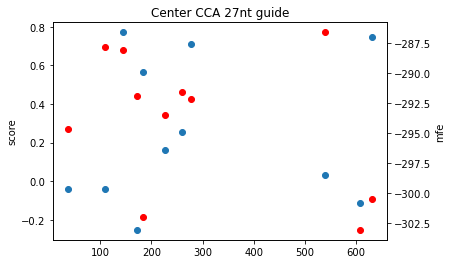

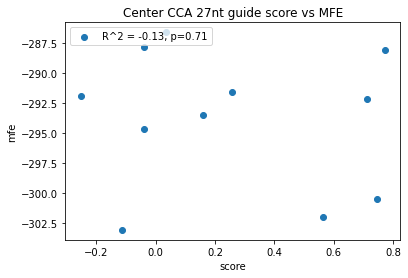

In [157]:
plot_dictionary_two_values(center_stop_27_data, title="Center CCA 27nt guide", ylabel0="score", ylabel1="mfe")
plot_values_in_dict(center_stop_27_data, title="Center CCA 27nt guide score vs MFE", xlabel="score", ylabel='mfe')

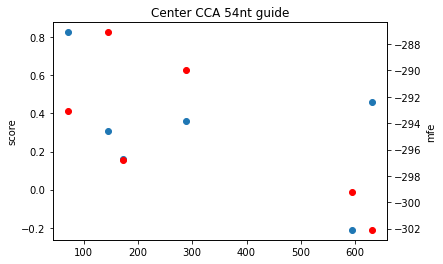

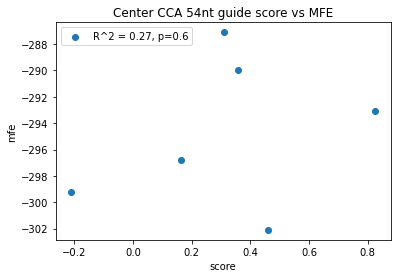

In [158]:
plot_dictionary_two_values(center_stop_54_data, title="Center CCA 54nt guide", ylabel0="score", ylabel1="mfe")
plot_values_in_dict(center_stop_54_data, title="Center CCA 54nt guide score vs MFE", xlabel="score", ylabel='mfe')

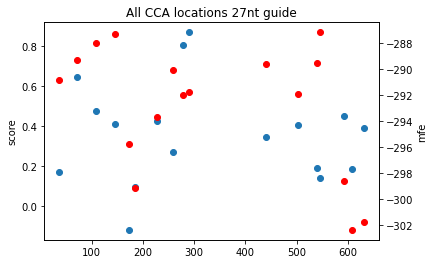

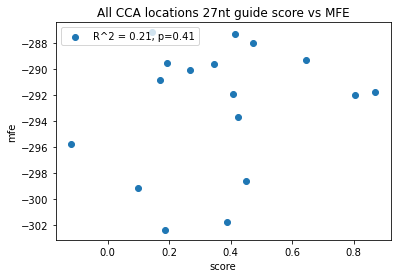

In [159]:
plot_dictionary_two_values(all_stops_27_data, title="All CCA locations 27nt guide", 
                           ylabel0="score", ylabel1="mfe")
plot_values_in_dict(all_stops_27_data, title="All CCA locations 27nt guide score vs MFE", 
                    xlabel="score", ylabel='mfe')

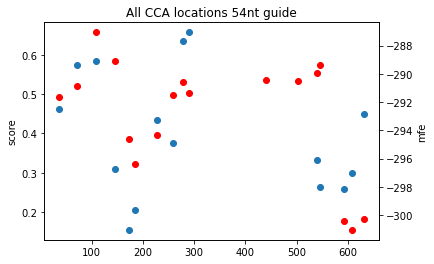

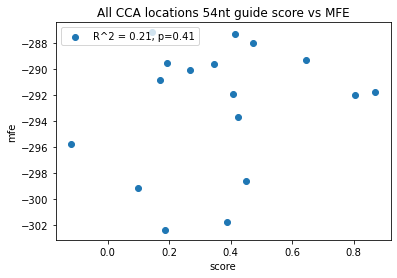

In [160]:
# plot_dictionary(all_stops_54_data, title="All CCA locations 54nt guide")
plot_dictionary_two_values(all_stops_54_data, title="All CCA locations 54nt guide", 
                           ylabel0="score", ylabel1="mfe")
plot_values_in_dict(all_stops_27_data, title="All CCA locations 54nt guide score vs MFE", 
                    xlabel="score", ylabel='mfe')

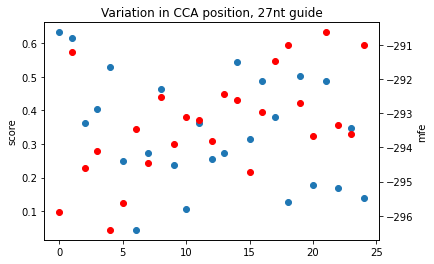

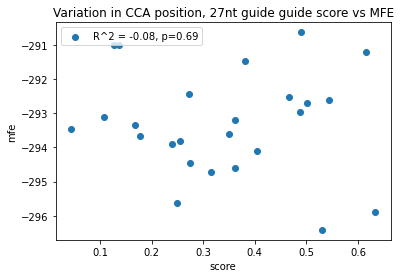

In [161]:
# plot_dictionary(stop_position_variation_27_data, title="Variation in CCA position, 27nt guide", 
#                 xlabel="CCA position in 27nt guide")
plot_dictionary_two_values(stop_position_variation_27_data, title="Variation in CCA position, 27nt guide", 
                           ylabel0="score", ylabel1="mfe")
plot_values_in_dict(stop_position_variation_27_data, 
                    title="Variation in CCA position, 27nt guide guide score vs MFE", 
                    xlabel="score", ylabel='mfe')

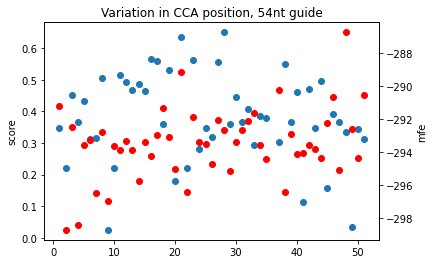

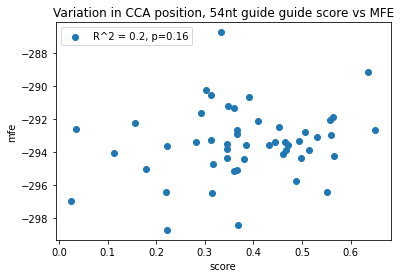

In [170]:
# plot_dictionary(stop_position_variation_54_data, title="Variation in CCA position, 54nt guide", 
#                 xlabel="CCA position in 27nt guide")
plot_dictionary_two_values(stop_position_variation_54_data, title="Variation in CCA position, 54nt guide", 
                           ylabel0="score", ylabel1="mfe")

for key in list(stop_position_variation_54_data.keys()):
    if np.isnan(stop_position_variation_54_data[key]).any():
        del stop_position_variation_54_data[key]
        
plot_values_in_dict(stop_position_variation_54_data, 
                    title="Variation in CCA position, 54nt guide guide score vs MFE", 
                    xlabel="score", ylabel='mfe')

## Secondary Analyses

In [189]:
center_vs_all_27 = {x : (center_stop_27_data[x][0], all_stops_27_data[x][0]) for x in center_stop_27_data.keys()}
center_vs_all_54 = {x : (center_stop_54_data[x][0] if x in center_stop_54_data else None, 
                         all_stops_54_data[x][0]) for x in all_stops_54_data.keys()}

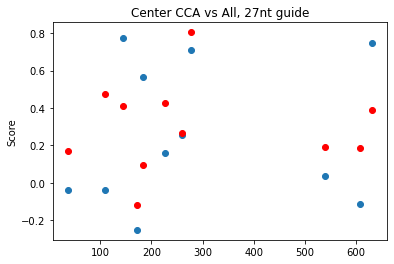

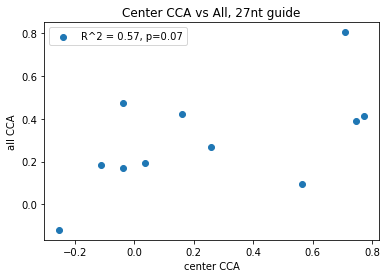

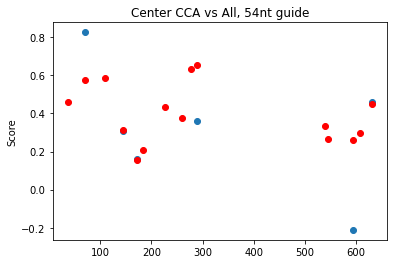

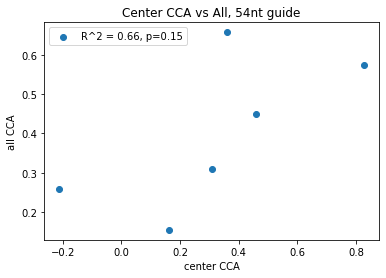

In [194]:
plot_dictionary_two_values(center_vs_all_27, title="Center CCA vs All, 27nt guide", 
                           ylabel0="Score", sameAxis=True)
plot_values_in_dict(center_vs_all_27, 
                    title="Center CCA vs All, 27nt guide", 
                    xlabel="center CCA", ylabel='all CCA')

plot_dictionary_two_values(center_vs_all_54, title="Center CCA vs All, 54nt guide", 
                           ylabel0="Score", sameAxis=True)
for k in list(center_vs_all_54.keys()):
    if not center_vs_all_54[k][0] or not center_vs_all_54[k][1]:
        del center_vs_all_54[k]
plot_values_in_dict(center_vs_all_54, 
                    title="Center CCA vs All, 54nt guide", 
                    xlabel="center CCA", ylabel='all CCA')